# Self-supervised learning with Masked Autoencoders on MNIST-1D
*Adapted from SSL notebook using simCLR:* self-supervised-learning.ipynb - https://github.com/greydanus/mnist1d/blob/master/notebooks/self-supervised-learning.ipynb

Copied and changed to work for Masked Autoencoder

In [91]:
%matplotlib inline

import pylab as plt
import numpy as np
import torch
import time

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Try attaching to GPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using:', DEVICE)

# Set the seed
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Figure style (loading from the web to make running in a Colab easier)
plt.style.use('https://github.com/greydanus/mnist1d/raw/master/notebooks/mpl_style.txt')

Using: cpu


In [92]:
# Load MNIST-1D
# (loading from the web to make running in a Colab easier)

from urllib.request import urlopen
import pickle

#url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
#data = pickle.load(urlopen(url))
data = pickle.load(open('../mnist1d_data.pkl', 'rb'))

print(data['x'].shape)
print(data['x_test'].shape)

(4000, 40)
(1000, 40)


In [93]:
# Classification accuracy in "pixel space"

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(data['x'], data['y'])
knn_acc = knn.score(data['x_test'], data['y_test']) * 100
print(f'kNN accuracy: {knn_acc:.1f}%')

lin = make_pipeline(StandardScaler(), LogisticRegression(tol=1e-2, max_iter=1000))
lin.fit(data['x'], data['y'])
lin_acc = lin.score(data['x_test'], data['y_test']) * 100
print(f'Linear accuracy: {lin_acc:.1f}%')

kNN accuracy: 59.6%
Linear accuracy: 33.3%


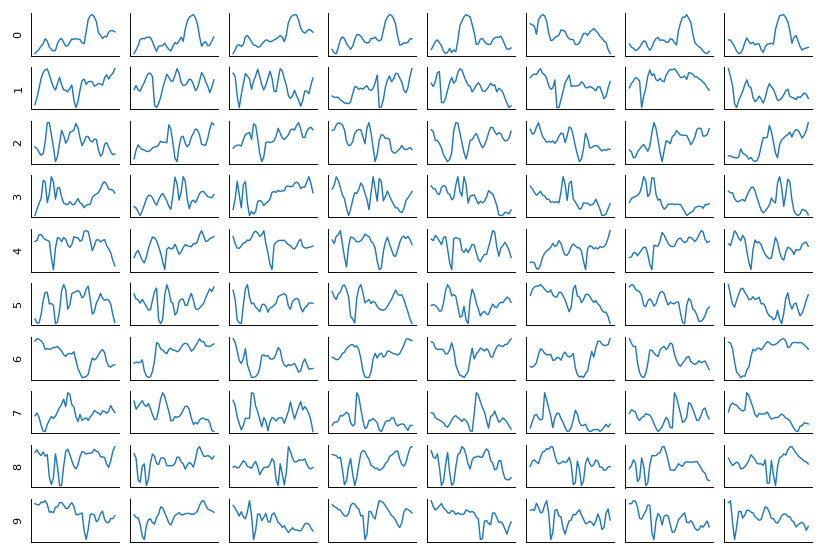

In [94]:
# Show digit examples

fig, axs = plt.subplots(nrows=10, ncols=8, figsize=(6, 4), layout='constrained')

for y in range(10):
    for i in range(8):
        axs[y, i].plot(data['x'][data['y'] == y][i])
        axs[y, i].set_xticks([])
        axs[y, i].set_yticks([])

    axs[y, 0].set_ylabel(y)

In [95]:
# Define model

class MAEModel(torch.nn.Module):
    def __init__(self, input_size, num_channels=25, hidden_dim=16, mask_ratio=0.0, linear = True, verbose=True):
        super(MAEModel, self).__init__()
        self.input_size = input_size
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        self.mask_ratio = mask_ratio
        self.linear = linear # If set = True, the encoder/decoder will have a 2 conv layers + 1 linear layer, otherwise only conv layers

        # Conv-Lin Encoder
        self.conv1 = torch.nn.Conv1d(1, num_channels, 5, stride=2, padding=1)
        self.conv2 = torch.nn.Conv1d(num_channels, num_channels, 3, stride=2, padding=1)

        dummy_input = torch.zeros(1, 1, int(input_size))  # Batch size of 1, single input channel
        conv_output = self.conv2(self.conv1(dummy_input))       # Forward pass to get output shape for linear encoder
        conv_out_size = conv_output.shape[1] * conv_output.shape[2]  # Channels x Length
        self.linear1 = torch.nn.Linear(conv_out_size, hidden_dim)

        # Conv-Lin Decoder
        self.linear2 = torch.nn.Linear(hidden_dim, conv_out_size)
        self.deconv1 = torch.nn.ConvTranspose1d(num_channels, num_channels, 3, stride=2, padding=1)
        self.deconv2 = torch.nn.ConvTranspose1d(num_channels, 1, 5, stride=2, padding=1, output_padding=1)

        if verbose:
            print("Initialized MAE with {} parameters".format(self.count_params()))
    
    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])


    def forward(self, x, decoder=True, all_layers=False):

        x = x.view(-1, x.shape[-1])  # Flatten the input for masking
        mask = torch.bernoulli(torch.ones_like(x) * (1 - self.mask_ratio)) # Create mask
        x_masked = x * mask # Apply mask

        # Encode
        x_masked = x_masked.view(-1, 1, x_masked.shape[-1])
        h1 = self.conv1(x_masked).relu()
        h2 = self.conv2(h1).relu()
        if self.linear:
            h2 = h2.view(h2.shape[0], -1) # flatten the conv features
            encoded = self.linear1(h2).relu()
        else:
            encoded = h2

        if not decoder:
            if not self.linear:
                encoded = encoded.view(-1, encoded.shape[1] * encoded.shape[2])
            return encoded

        # Decode
        if self.linear:
            h3 = self.linear2(encoded).relu()
            h3 = h3.view(-1, self.num_channels, h2.shape[-1] // self.num_channels)
            h4 = self.deconv1(h3).relu()
        else:
            h4 = self.deconv1(encoded).relu()
        
        decoded = self.deconv2(h4).relu()
        decoded = decoded.view(-1, self.input_size)

        if all_layers:
            if self.linear:
                return [h1.view(h1.shape[0], -1), h2, encoded, h3.view(h4.shape[0], -1), h4.view(h4.shape[0], -1), decoded]
            else:
                return [h1.view(h1.shape[0], -1), h2.view(h2.shape[0], -1), encoded.view(encoded.shape[0], -1), h4.view(h4.shape[0], -1), decoded]


        return decoded

In [96]:
# Set up training

def train(dataset, model, lr=0.01, n_epochs=100, batch_size=100, print_every_epoch=10):

    optimizer = torch.optim.Adam(model.parameters(), lr)

    x = torch.Tensor(dataset['x']).to(DEVICE)
    x_test = torch.Tensor(dataset['x_test']).to(DEVICE)
    model = model.to(DEVICE)

    # We train on both the training and testing sets combined
    x_all = torch.cat((x, x_test), 0)

    knn_acc = np.nan
    lin_acc = np.nan
        
    t0 = time.time()
    for epoch in range(n_epochs):
        acc_loss = 0

        shuffle = np.random.permutation(len(x_all))

        for batch in range(len(x_all) // batch_size):
            batch_ind = np.arange(batch * batch_size, (batch + 1) * batch_size)
            batch = x_all[shuffle][batch_ind]

            # Pass both views through the model
            decoded = model(batch)

            loss = torch.mean((decoded - batch) ** 2)

            acc_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Evaluate and print
        if (epoch + 1) % print_every_epoch == 0:
            t1 = time.time()
            mean_loss = acc_loss / (len(x) // batch_size)
            mean_time = (t1 - t0) / print_every_epoch

            # Compute test set classification accuracy
            model.eval()
            with torch.no_grad():
                knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
                knn.fit(model(x).detach().numpy(), dataset['y'])
                knn_acc = knn.score(model(x_test).detach().numpy(), dataset['y_test']) * 100

                lin = make_pipeline(StandardScaler(), LogisticRegression(tol=1e-2, max_iter=1000))
                lin.fit(model(x, decoder=False).detach().numpy(), dataset['y'])
                lin_acc = lin.score(model(x_test, decoder=False).detach().numpy(), dataset['y_test']) * 100
            model.train()

            print(f'Epoch {epoch + 1:3.0f}, loss per batch {mean_loss:.2f}, val kNN acc Z: {knn_acc:4.1f}, val lin acc H: {lin_acc:4.1f}, time per epoch {mean_time:.1f}s')
            t0 = t1

    return acc_loss / (len(x_all) // batch_size), knn_acc, lin_acc

In [97]:
# Train the model and pass the entire dataset through it (before/after)

set_seed(42)

model = MAEModel(input_size=data['x'].shape[-1], mask_ratio = 0.0, hidden_dim=12, num_channels=25, linear = False)

Z0 = model(torch.Tensor(data['x']).to(DEVICE)).detach().numpy()

train(data, model, lr=0.01, n_epochs=200, batch_size=100)

Z = model(torch.Tensor(data['x']).to(DEVICE)).detach().numpy()
H = model(torch.Tensor(data['x']).to(DEVICE), decoder=False).detach().numpy()

Initialized MAE with 10338 parameters
Epoch  10, loss per batch 0.64, val kNN acc Z: 30.7, val lin acc H: 44.2, time per epoch 0.8s
Epoch  20, loss per batch 0.64, val kNN acc Z: 31.0, val lin acc H: 44.2, time per epoch 0.9s
Epoch  30, loss per batch 0.64, val kNN acc Z: 31.6, val lin acc H: 44.7, time per epoch 0.9s
Epoch  40, loss per batch 0.64, val kNN acc Z: 31.7, val lin acc H: 44.9, time per epoch 0.9s
Epoch  50, loss per batch 0.64, val kNN acc Z: 32.0, val lin acc H: 45.0, time per epoch 0.9s
Epoch  60, loss per batch 0.64, val kNN acc Z: 30.8, val lin acc H: 45.1, time per epoch 0.9s
Epoch  70, loss per batch 0.64, val kNN acc Z: 31.1, val lin acc H: 45.2, time per epoch 0.9s
Epoch  80, loss per batch 0.64, val kNN acc Z: 31.2, val lin acc H: 44.6, time per epoch 0.9s
Epoch  90, loss per batch 0.64, val kNN acc Z: 30.9, val lin acc H: 48.3, time per epoch 0.8s
Epoch 100, loss per batch 0.64, val kNN acc Z: 31.5, val lin acc H: 49.3, time per epoch 0.9s
Epoch 110, loss per ba

In [98]:
# Visualise using t-SNE

T  = TSNE(metric='cosine', n_jobs=-1).fit_transform(Z)
T0 = TSNE(metric='cosine', n_jobs=-1).fit_transform(Z0)

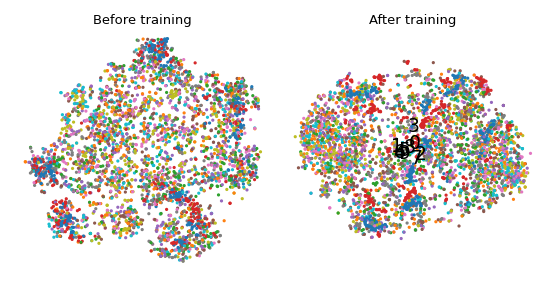

In [99]:
# Plot the visualisation

fig, axs = plt.subplots(ncols=2, figsize=(4, 2), layout='constrained')

axs[0].scatter(T0[:,0], T0[:,1], c=data['y'], s=2, cmap='tab10')
axs[0].set_aspect('equal', 'datalim')
axs[0].set_title('Before training')
axs[0].axis('off')

axs[1].scatter(T[:,0], T[:,1], c=data['y'], s=2, cmap='tab10')
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title('After training')
axs[1].axis('off')

for y in range(10):
    mu = np.median(T[data['y'] == y], axis=0)
    axs[1].text(mu[0], mu[1], y, fontsize=10, ha='center', va='center')

In [100]:
# Evaluate every layer

lin = make_pipeline(StandardScaler(), LogisticRegression(tol=1e-2, max_iter=1000))

L_train = model(torch.Tensor(data['x']), all_layers=True)
L_train = [l.detach().numpy() for l in L_train]
L_train = [data['x']] + L_train

L_test = model(torch.Tensor(data['x_test']), all_layers=True)
L_test = [l.detach().numpy() for l in L_test]
L_test = [data['x_test']] + L_test

acc = np.zeros(len(L_train))

for i in range(len(L_train)):
    lin.fit(L_train[i], data['y'])
    acc[i] = lin.score(L_test[i], data['y_test']) * 100
    print(f'Layer {i}: linear accuracy {acc[i]:.1f}')

Layer 0: linear accuracy 33.3
Layer 1: linear accuracy 58.8
Layer 2: linear accuracy 48.3
Layer 3: linear accuracy 48.3
Layer 4: linear accuracy 49.9
Layer 5: linear accuracy 27.2
